In [37]:
import os 
import sys

import sklearn as sk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import xgboost as xgb

from scipy.stats import kurtosis, entropy
from scipy.fft import fft

sys.path.append(r"c:\Users\keng-tse\Desktop\csi_tool") #這行為絕對路徑，如需使用，必須要修改為當前決路徑
import csi_tool
import denoise 

In [39]:
base_path = r"C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone\1221_phone\5G\20Mhz\csv"
reference_points = {}

base_path2 = r"C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone\1222_phone\5G\20Mhz\csv"
reference_points2 = {}

# 每個點的實際位置 (x, y)，基於 0.6m 的間距
spacing = 0.6  # 每隔 0.6m
coordinates = {
    # 下邊界 (1-10 和 40-31)
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),

    # 左邊界 (1-11)
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
    6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),

    # 上邊界 (11-21)
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0),

    # 右邊界 (21-31)
    22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
    26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),

    # 中間點 (41-49)
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
    44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
    47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

# 生成 reference_points 字典
for ref_id, coord in coordinates.items():
    folder_path = os.path.join(base_path, f"reference_point_{ref_id}.xlsx")
    reference_points[folder_path] = (ref_id, coord)

# 打印結果
for path, (ref_id, coord) in reference_points.items():
    print(f"Path: {path}, ID: {ref_id}, Coordinates: {coord}")


# 生成 reference_points 字典
for ref_id, coord in coordinates.items():
    folder_path2 = os.path.join(base_path2, f"reference_point_{ref_id}.xlsx")
    reference_points2[folder_path2] = (ref_id, coord)

# 打印結果
for path, (ref_id, coord) in reference_points2.items():
    print(f"Path: {path}, ID: {ref_id}, Coordinates: {coord}")



Path: C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone\1221_phone\5G\20Mhz\csv\reference_point_1.xlsx, ID: 1, Coordinates: (0, 0)
Path: C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone\1221_phone\5G\20Mhz\csv\reference_point_40.xlsx, ID: 40, Coordinates: (0.6, 0)
Path: C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone\1221_phone\5G\20Mhz\csv\reference_point_39.xlsx, ID: 39, Coordinates: (1.2, 0)
Path: C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone\1221_phone\5G\20Mhz\csv\reference_point_38.xlsx, ID: 38, Coordinates: (1.8, 0)
Path: C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone\1221_phone\5G\20Mhz\csv\reference_point_37.xlsx, ID: 37, Coordinates: (2.4, 0)
Path: C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone\1221_phone\5G\20Mhz\csv\reference_point_36.xlsx, ID: 36, Coordinates: (3.0, 0)
Path: C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone\1221_phone\5G\20Mhz\csv\re

In [41]:
def load_data(reference_points):
    data = []          # 用于存储所有数据
    rp_labels = []     # 用于存储参考点编号标签
    coord_labels = []  # 用于存储 (x, y) 坐标标签

    for path, (ref_id, coord) in reference_points.items():
        df = pd.read_excel(path)
        data.append(df.values)
        rp_labels.extend([ref_id] * len(df))
        coord_labels.extend([coord] * len(df))
    data = pd.DataFrame(np.vstack(data))
    rp_labels = pd.Series(rp_labels, name="Reference Point ID")
    coord_labels = pd.DataFrame(coord_labels, columns=["X", "Y"])
    return data, rp_labels, coord_labels

In [43]:
data, rp_labels, coord_labels = load_data(reference_points)

In [45]:
# 分離CFR和CIR數據
CFR_data = data.iloc[:, :48]  # 前 48 列是CFR
CIR_data = data.iloc[:, 48:]  # 後 48 列是CIR

# 將 CFR 和 CIR 轉換為 dB（如果需要）
def to_db(amplitude):
    # 防止對零取對數
    return 10 * np.log10(np.maximum(amplitude, 1e-10))

print(CFR_data.shape)

#CFR_data_ham = denoise.hampel_filter(np.array(CFR_data))

#CFR_data_ham_mmf = denoise.moving_median_filter(CFR_data_ham, 5)

#cfr_db = to_db(CFR_data_ham)

#cir_db = to_db(CIR_data)


# 使用參考點 ID 作為分類標籤
y_class = rp_labels

# 使用座標作為回歸標籤
y_reg = coord_labels

(24210, 48)


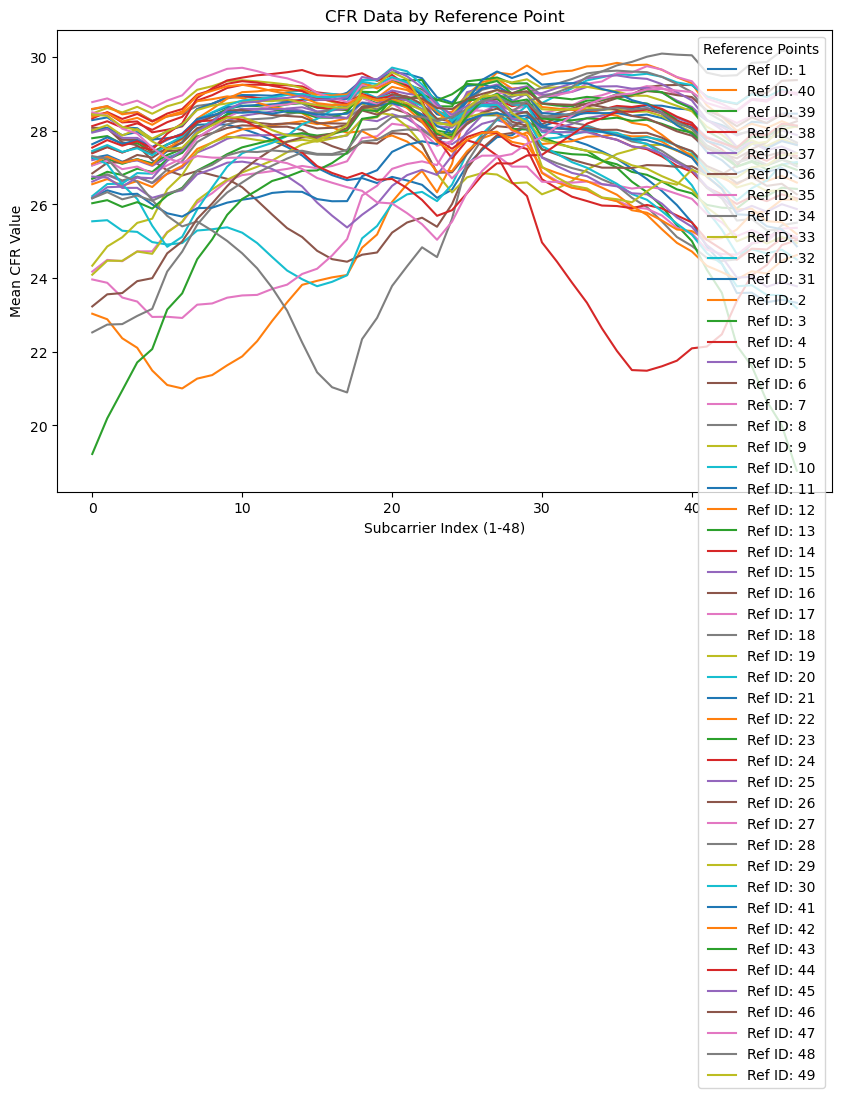

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Separate CFR data (first 48 columns)
#CFR_data = data.iloc[:, :48]

# Create a plot for each reference point label
unique_ref_ids = rp_labels.unique()

# Set up the figure and axis for plotting
plt.figure(figsize=(10, 6))

for ref_id in unique_ref_ids:
    # Select CFR data corresponding to each reference point
    ref_data = cfr_db[rp_labels == ref_id]
    
    # Plot the mean CFR for each reference point
    # You can also plot individual samples by looping through ref_data if you prefer
    plt.plot(np.mean(ref_data, axis=0), label=f"Ref ID: {ref_id}")

plt.title("CFR Data by Reference Point")
plt.xlabel("Subcarrier Index (1-48)")
plt.ylabel("Mean CFR Value")
plt.legend(title="Reference Points")
plt.show()


In [7]:

import os
import matplotlib.pyplot as plt

def save_individual_cfr_plots_by_label(data, rp_labels, save_dir=r"C:\Users\keng-tse\Desktop\csi-plot\csi20Hz_1221\phase"):
    # Create directory to save files if it does not exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Separate CFR data (first 48 columns)
    #CFR_data = data.iloc[:, :48]

    # Iterate through each reference point ID and save a plot
    unique_ref_ids = rp_labels.unique()
    for ref_id in unique_ref_ids:
        # Select CFR data corresponding to the current reference point ID
        ref_data = data[rp_labels == ref_id]
        
        # Create a plot for the reference point
        plt.figure(figsize=(10, 6))

        # Plot each sample (line plot for each packet)
        for i in range(ref_data.shape[0]):
            plt.plot(ref_data[i, :], label=f"Sample {i+1}", alpha=0.6)

        plt.title(f"CFR Data for Reference Point {ref_id}")
        plt.xlabel("Subcarrier Index (1-48)")
        plt.ylabel("CFR Value")
        plt.grid(True)
        # plt.legend(title="Samples", bbox_to_anchor=(1.05, 1), loc='upper left')

        # Define the file name using the reference point ID
        file_name = f"{save_dir}/ref_point_{ref_id}.png"
        
        # Save the plot as a PNG image
        plt.savefig(file_name, bbox_inches="tight")
        plt.close()  # Close the plot to free up memory
        print(f"Saved CFR plot for Reference Point {ref_id} to {file_name}")

# Call the function to save CFR plots by reference point label
save_individual_cfr_plots_by_label(np.array(CIR_data), rp_labels)


Saved CFR plot for Reference Point 1 to C:\Users\keng-tse\Desktop\csi-plot\csi20Hz_1221\phase/ref_point_1.png
Saved CFR plot for Reference Point 40 to C:\Users\keng-tse\Desktop\csi-plot\csi20Hz_1221\phase/ref_point_40.png
Saved CFR plot for Reference Point 39 to C:\Users\keng-tse\Desktop\csi-plot\csi20Hz_1221\phase/ref_point_39.png
Saved CFR plot for Reference Point 38 to C:\Users\keng-tse\Desktop\csi-plot\csi20Hz_1221\phase/ref_point_38.png
Saved CFR plot for Reference Point 37 to C:\Users\keng-tse\Desktop\csi-plot\csi20Hz_1221\phase/ref_point_37.png
Saved CFR plot for Reference Point 36 to C:\Users\keng-tse\Desktop\csi-plot\csi20Hz_1221\phase/ref_point_36.png
Saved CFR plot for Reference Point 35 to C:\Users\keng-tse\Desktop\csi-plot\csi20Hz_1221\phase/ref_point_35.png
Saved CFR plot for Reference Point 34 to C:\Users\keng-tse\Desktop\csi-plot\csi20Hz_1221\phase/ref_point_34.png
Saved CFR plot for Reference Point 33 to C:\Users\keng-tse\Desktop\csi-plot\csi20Hz_1221\phase/ref_point_3

In [47]:
# scaler = StandardScaler()
# cfr_scaled = scaler.fit_transform(cfr_db)
# cir_scaled = scaler.fit_transform(cir_db)

# X = np.concat([cfr_db, cir_db], axis = 1)

In [103]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=30)
# data_pca = pca.fit_transform(CFR_data)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(data, y_class, test_size=0.2, random_state=42)

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

knn = KNeighborsClassifier(n_neighbors=5)


knn.fit(X_train, y_train)


y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 99   0   0 ...   0   0   0]
 [  0 102   0 ...   0   0   0]
 [  0   0  91 ...   0   0   0]
 ...
 [  0   0   0 ...  90   0   0]
 [  0   0   0 ...   0 105   0]
 [  0   0   0 ...   0   0 100]]
              precision    recall  f1-score   support

           1       0.93      0.98      0.96       101
           2       0.96      0.99      0.98       103
           3       0.99      1.00      0.99        91
           4       0.97      0.99      0.98       103
           5       0.97      0.99      0.98        75
           6       1.00      0.99      0.99        99
           7       1.00      0.97      0.99       113
           8       1.00      0.99      1.00       107
           9       0.97      1.00      0.98        88
          10       0.99      0.99      0.99       101
          11       1.00      0.99      1.00       112
          12       1.00      1.00      1.00        97
          13       0.99      0.98      0.99       102
          14       0.99      1.00      0.99        

In [121]:
# from sklearn.preprocessing import LabelEncoder

# xgb_model = xgb.XGBClassifier()

# # 假設 labels 是你的原始標籤
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y_train)  # 編碼 y_train

# # 重新訓練模型
# xgb_model.fit(X_train, y_encoded)

# # 在預測階段，將預測結果轉換回原始標籤
# y_pred_encoded = xgb_model.predict(X_test)
# y_pred = label_encoder.inverse_transform(y_pred_encoded)  # 轉換回原始標籤

# # 計算準確度
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")

# # 顯示分類報告和混淆矩陣
# print("Classification Report:")
# print(classification_report(y_test, y_pred))
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))


In [111]:
data2, rp_labels2, coord_labels2 = load_data(reference_points2)

In [112]:
CFR_data2 = data2.iloc[:, :48]  # 前 48 列是CFR
CIR_data2 = data2.iloc[:, 48:]  # 後 48 列是CIR

In [123]:
y_pred2 = knn.predict(data2)

print(confusion_matrix(rp_labels2, y_pred2))
print(classification_report(rp_labels2, y_pred2))

[[401   0   0 ...   0   0   0]
 [  0   1  18 ...   0   0   0]
 [  0  12  73 ...   0   0   0]
 ...
 [  2   0   0 ...   2   0  56]
 [  0   0   0 ...   0 278   0]
 [  0   0   9 ...   0   0   1]]
              precision    recall  f1-score   support

           1       0.34      0.82      0.48       487
           2       0.00      0.00      0.00       495
           3       0.23      0.15      0.18       495
           4       0.00      0.00      0.00       498
           5       0.36      0.53      0.43       493
           6       0.50      0.70      0.58       494
           7       0.00      0.00      0.00       498
           8       0.00      0.00      0.00       493
           9       0.00      0.00      0.00       496
          10       0.00      0.00      0.00       494
          11       0.43      0.85      0.57       494
          12       0.00      0.00      0.00       459
          13       0.98      0.10      0.17       492
          14       0.00      0.00      0.00       4

In [31]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(CFR_data2,rp_labels2, test_size=0.2, random_state=42)

In [35]:
knn = KNeighborsClassifier(n_neighbors=5)


knn.fit(X_train2, y_train2)


y_pred2 = knn.predict(X_test2)

print(confusion_matrix(y_test2, y_pred2))
print(classification_report(y_test2, y_pred2))

[[ 98   0   0 ...   0   0   0]
 [  0  93   0 ...   0   0   0]
 [  0   0  93 ...   0   0   0]
 ...
 [  0   0   0 ...  92   0   0]
 [  0   0   0 ...   0 109   0]
 [  0   0   0 ...   0   0 109]]
              precision    recall  f1-score   support

           1       0.98      0.98      0.98       100
           2       0.98      0.98      0.98        95
           3       1.00      1.00      1.00        93
           4       0.96      1.00      0.98        97
           5       0.99      0.99      0.99        78
           6       0.97      1.00      0.99       112
           7       1.00      0.99      1.00       120
           8       1.00      0.98      0.99       109
           9       1.00      1.00      1.00        86
          10       0.99      1.00      0.99        94
          11       1.00      1.00      1.00       104
          12       1.00      1.00      1.00        86
          13       1.00      1.00      1.00       104
          14       0.97      1.00      0.98        